# Time series analysis - Example code 13: Predicting the tobacco production (see also code 4)

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')


from tsa_lth.modelling import estimateARMA
from tsa_lth.analysis import acf, normplot, naive_pred
from tsa_lth.tests import whiteness_test, check_if_normal
from tsa_lth.tools.poly import polydiv

## Load the tobacco production data

In [2]:
# Load tobacco data
df = pd.read_csv('../data/tobacco_data.csv')
data = df['production'].values
time = df['year'].values

print(f"Data shape: {data.shape}")
print(f"Years: {time[0]} to {time[-1]}")

Data shape: (114,)
Years: 1871 to 1984


## Divide data into model and validation data sets

At first, limit the validation data as it seems the statistics change. Does it make a difference? How could one determine if there has been a trend change?

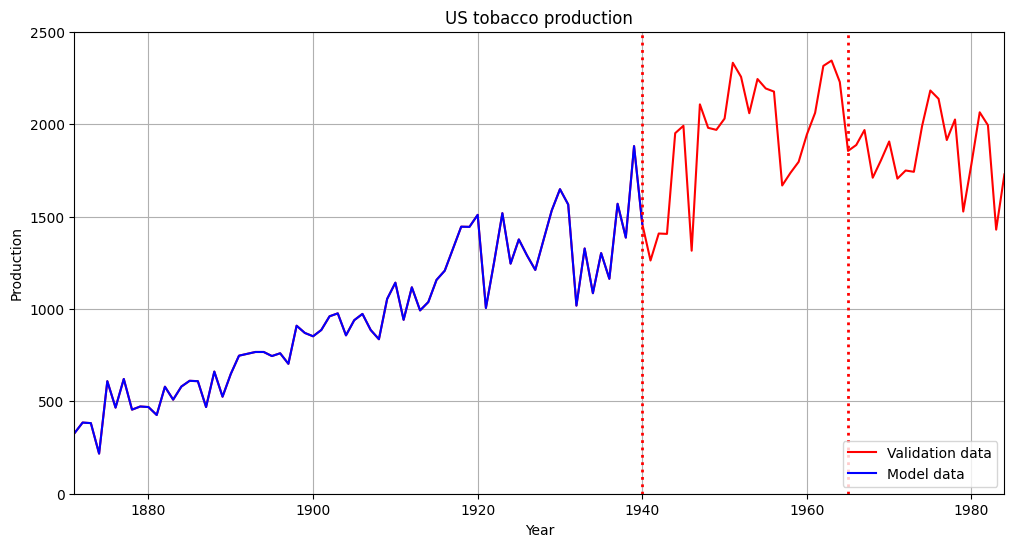

In [3]:
N = 95
# N = len(data)  # Alternative: use all data
modelLim = 70
modelData = data[:modelLim]

plt.figure(figsize=(12, 6))
plt.plot(time, data, 'r', label='Validation data')
plt.plot(time[:modelLim], modelData, 'b', label='Model data')
plt.axvline(x=time[modelLim-1], color='red', linestyle=':', linewidth=2)
plt.axvline(x=time[N-1], color='red', linestyle=':', linewidth=2)
plt.xlim([time[0], time[-1]])
plt.ylim([0, 2500])
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend(loc='lower right')
plt.title('US tobacco production')
plt.grid(True)
plt.show()

noLags = 20

# For debugging, try generating data that has similar characteristics:
# N = 10000
# extraN = 100
# time = np.arange(1, N+1)
# C = np.array([1])
# A = np.convolve([1, -1], [1, 0.37])
# e = np.random.randn(N + extraN)
# data = lfilter(C, A, e)
# data = data[extraN:] + 1000
# modelData = data[:N-1000]
# plt.figure()
# plt.plot(data)
# plt.show()
# noLags = 100

## Estimate unknown parameters with the model structure found in code 4

Differentiate to remove trend. Note that the found model is in the differentiated domain!

In [4]:
# Differentiate to remove trend
y = lfilter([1, -1], 1, modelData.astype(float))
y = y[1:]  # Remove first sample

print(f"Differentiated data shape: {y.shape}")

Differentiated data shape: (69,)


Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 + 0.5485(±0.1053)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 14.18%
FPE : 25097.832  MSE : 25173.766
AIC : 884.058   BIC : 886.277



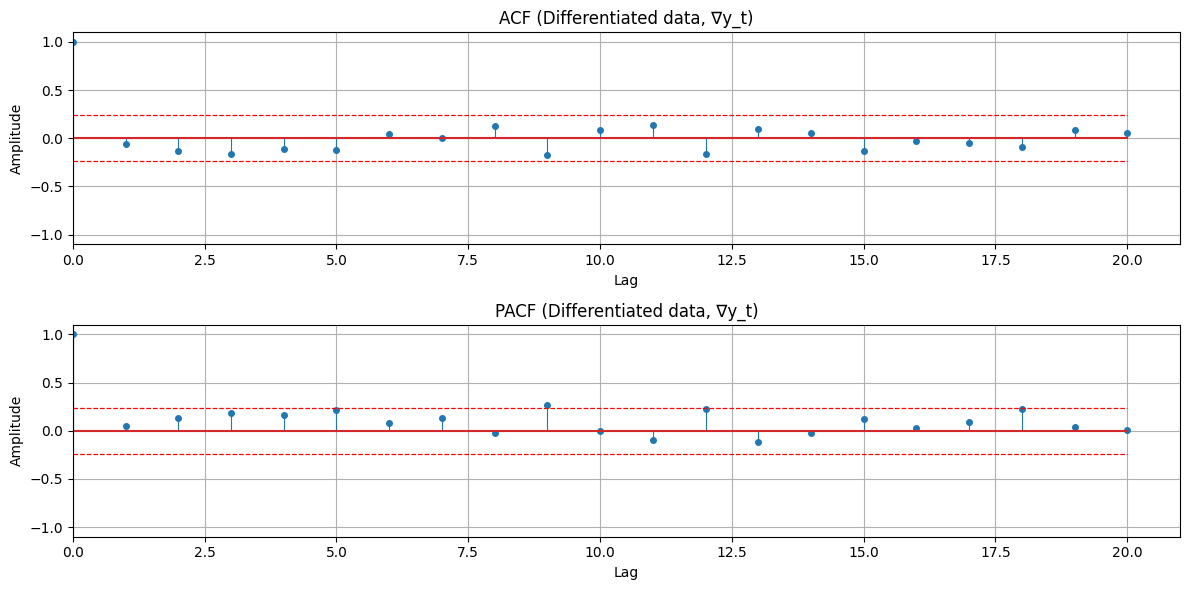

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 21.87 < 37.65)
  McLeod-Li test:        True (white if 24.85 < 37.65)
  Monti test:            True (white if 35.38 < 37.65)
  Sign change test:      True (white if 0.52 in [0.38,0.62])


In [5]:
# Estimate ARMA model on differentiated data
# Note that the found model is in the differentiated domain!
foundModel = estimateARMA(y, A=[1, 1], C=[1], 
                          titleStr='Differentiated data, ∇y_t', 
                          noLags=noLags)

## Let's form the k-step prediction

Predict future values. Some important things to note:
1. We start the prediction long before the validation data - here from the beginning of the modeling data. This to save data; recall that we need to omit ord(G) samples.
2. The G polynomial will start with k zeros. It is (in general) not monic and is of order max(p-1, q-k).
3. The F polynomial is monic of order k-1.

In [6]:
k = 3  # Prediction horizon; try other k, e.g., k=5

# Form the A polynomial taking the differentiation into account
A_full = np.convolve([1, -1], foundModel.A)
print(f"A polynomial (with differentiation): {A_full}")
print(f"C polynomial: {foundModel.C}")

# Compute the G and F polynomials
F, G = polydiv(foundModel.C, A_full, k)
print(f"\nF = {F}")
print(f"G = {G}")

# Form the predicted data
yhatk = lfilter(G, foundModel.C, data.astype(float))
print(f"\nPrediction complete. Shape: {yhatk.shape}")

A polynomial (with differentiation): [ 1.         -0.45146583 -0.54853417]
C polynomial: [1.]

F = [1.         0.45146583 0.75235557]
G = [0.         0.         0.         0.58730726 0.41269274]

Prediction complete. Shape: (114,)


## Plot the predictions

Looking at the predictions, note that the initial k predicted values are zeros due to the zeros in the G polynomial.

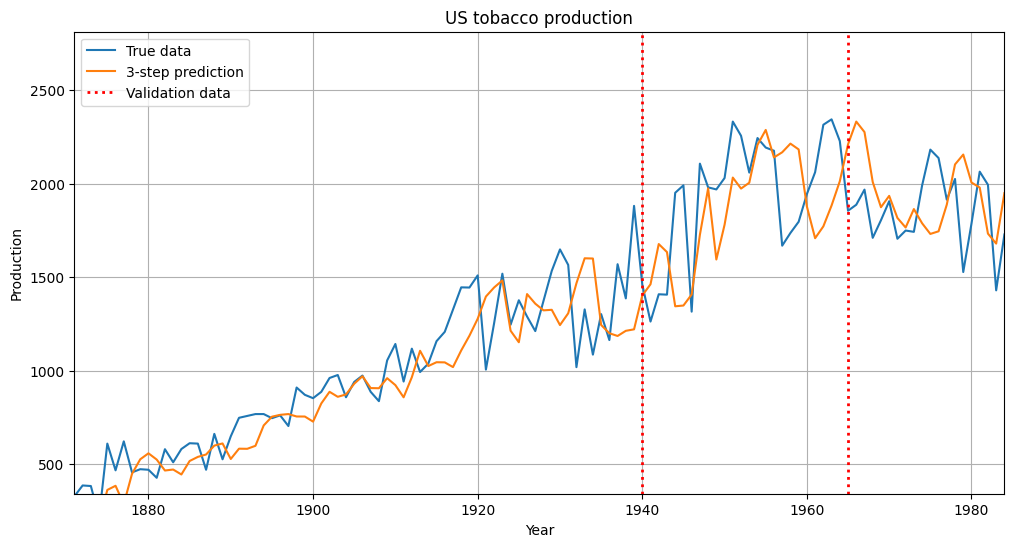

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='True data')
plt.plot(time, yhatk, label=f'{k}-step prediction')
plt.axvline(x=time[modelLim-1], color='red', linestyle=':', linewidth=2, label='Validation data')
plt.axvline(x=time[N-1], color='red', linestyle=':', linewidth=2)

y_min = 0.8 * np.min(data[10:])
y_max = 1.2 * np.max(data[10:])
plt.xlim([time[0], time[-1]])
plt.ylim([y_min, y_max])
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend(loc='upper left')
plt.title('US tobacco production')
plt.grid(True)
plt.show()

## How does the model work?

We focus only on the validation data. Note that we now also remove the initial corrupted samples due to the filtering.

In [8]:
# Calculate prediction residual for validation data
ehat = data - yhatk
ehat = ehat[modelLim:N]

print(f"Prediction residual shape: {ehat.shape}")
print(f"Mean: {np.mean(ehat):.4f}, Std: {np.std(ehat, ddof=1):.4f}")

Prediction residual shape: (25,)
Mean: 80.3148, Std: 339.3377


Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 11.20 < 19.68)
  McLeod-Li test:        True (white if 10.87 < 19.68)
  Monti test:            True (white if 10.88 < 19.68)
  Sign change test:      True (white if 0.33 in [0.30,0.70])


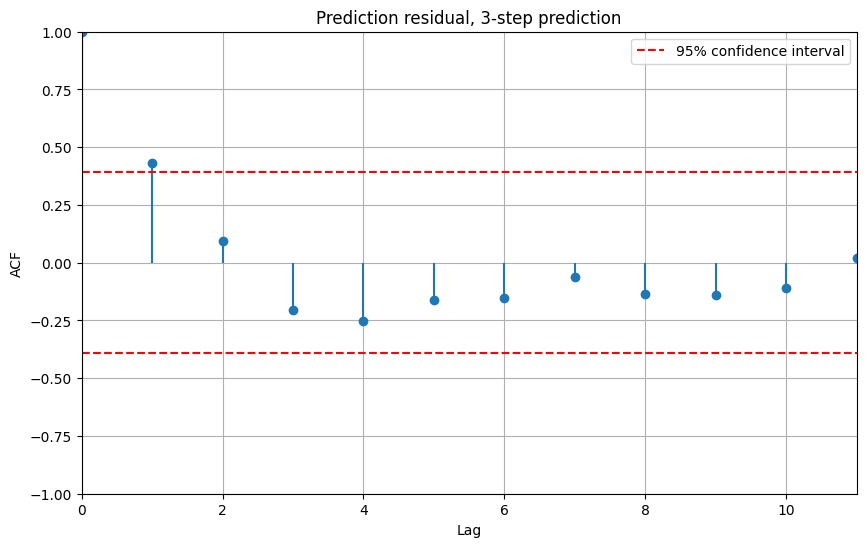

This is a 3-step prediction. Ideally, the residual should be an MA(2) process.


In [9]:
# Check whiteness - adjust noLags for small sample size
# Note that the prediction residual should only be white if k=1.
noLags_test = min(noLags, len(ehat) // 2 - 1)
whiteness_test(ehat, K=noLags_test)

# Plot ACF
acfEst = acf(ehat, noLags_test)

plt.figure(figsize=(10, 6))
plt.stem(range(len(acfEst)), acfEst, basefmt=' ')

# Confidence interval
conf_int = 1.96 / np.sqrt(len(ehat))
plt.axhline(y=conf_int, color='r', linestyle='--', label='95% confidence interval')
plt.axhline(y=-conf_int, color='r', linestyle='--')

plt.xlim([0, noLags_test])
plt.ylim([-1, 1])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title(f'Prediction residual, {k}-step prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f'This is a {k}-step prediction. Ideally, the residual should be an MA({k-1}) process.')

## What does the D'Agostino-Pearson's K² test indicate?

As the PACF should ring for an MA(k-1) process, we only check the ACF.

D'Agostino-Pearson's K² test for ACF:
The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


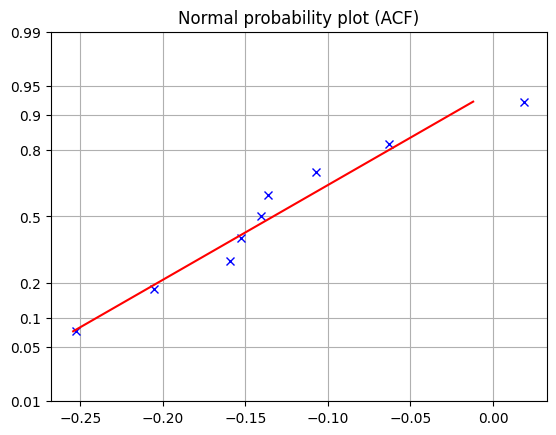

In [10]:
print("D'Agostino-Pearson's K² test for ACF:")
check_if_normal(acfEst[k:])
normplot(acfEst[k:], titleStr='ACF')

## Let's compare with a naive predictor

If we assume no seasonality, the current sample might be a reasonable guess. This will cause a prediction that is delayed k steps.

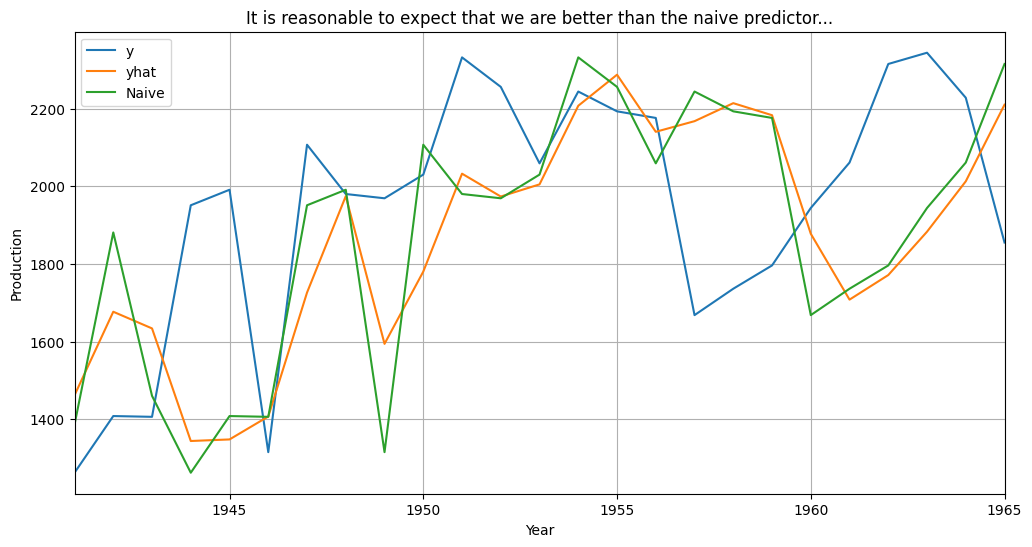

Prediction the signal 3-steps ahead.
  The variance of the prediction residual is       110544.06
  The variance of the naive prediction residual is 127024.24


In [11]:
testDataInd = np.arange(modelLim, N)
yNaive, var_naive, ehatN = naive_pred(data, testDataInd, k)

plt.figure(figsize=(12, 6))
plt.plot(time[testDataInd], data[testDataInd], label='y')
plt.plot(time[testDataInd], yhatk[testDataInd], label='yhat')
plt.plot(time[testDataInd], yNaive, label='Naive')
plt.title('It is reasonable to expect that we are better than the naive predictor...')
plt.xlim([time[modelLim], time[N-1]])
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

print(f'Prediction the signal {k}-steps ahead.')
print(f'  The variance of the prediction residual is       {np.var(ehat, ddof=0):5.2f}')
print(f'  The variance of the naive prediction residual is {var_naive:5.2f}')